# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)
7. [Evaluate](#evaluate)
7. [Metrics](#metrics)
8. [Plots](#plots)

<a name=imports></a>
## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import preprocessing

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


***
<a name=data></a>
## Data

### Ingestion
Load in the dataset as pandas dataframe.

In [3]:
# Check preprocessing.py for implementation
(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df) = preprocessing.ingestion()

Parent Directory /covid19-prediction/models
Path: /covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True
India Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-01-30        NaN     NaN        NaN
1  2020-01-31        0.0     0.0        0.0
2  2020-02-01        0.0     0.0        0.0
3  2020-02-02        1.0     0.0        0.0
4  2020-02-03        1.0     0.0        0.0 

India Vacc:
          Date  Total_Doses
0  2020-01-30          0.0
1  2020-01-31          0.0
2  2020-02-01          0.0
3  2020-02-02          0.0
4  2020-02-03          0.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-12        NaN     NaN        NaN
1  2020-04-13    25255.0  1542.0    11785.0
2  2020-04-14    26694.0  2327.0     6484.0
3  2020-04-15    29318.0  2474.0     6093.0
4  2020-04-16    31235.0  4607.0     5234.0 

USA Vacc:
          Date  Total_Doses
0  2020-04-12          0.0
1  2020-04-13          0.0
2  2020-04-14          0.0
3  2020-

### Pre-Processing
Filter out unnecessary columns. 

#### Multivariate

In [4]:
# Check preprocessing.py for implementation
# Number of Null in India - 563
# Number of Null in USA - 261
(india_multi, usa_multi) = preprocessing.multivariate(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df)

India:
          Date  Confirmed  Total_Doses
0  2020-01-30        NaN          0.0
1  2020-01-31        0.0          0.0
2  2020-02-01        0.0          0.0
3  2020-02-02        1.0          0.0
4  2020-02-03        1.0          0.0
USA:
          Date  Confirmed  Total_Doses
0  2020-04-12        NaN          0.0
1  2020-04-13    25255.0          0.0
2  2020-04-14    26694.0          0.0
3  2020-04-15    29318.0          0.0
4  2020-04-16    31235.0          0.0


#### Univariate 

In [5]:
# Check preprocessing.py for implementation
# Number of Null in India - 0
# Number of Null in USA - 0
(india_cases_uni, usa_cases_uni) = preprocessing.univariate(india_cases_df, usa_cases_df)

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    25255.0
2    26694.0
3    29318.0
4    31235.0
5    32175.0 



### Drop Null
Merging the vaccination and #cases datasets together for multivariate time series produces null values. Dropping the nuWe solve this by dropping the null values.ll values ensures that we take an inner join.

In [6]:
(india_multi, usa_multi) = preprocessing.dropNull(india_multi, usa_multi)

India:
          Date  Confirmed  Total_Doses
1  2020-01-31        0.0          0.0
2  2020-02-01        0.0          0.0
3  2020-02-02        1.0          0.0
4  2020-02-03        1.0          0.0
5  2020-02-04        0.0          0.0
USA:
          Date  Confirmed  Total_Doses
1  2020-04-13    25255.0          0.0
2  2020-04-14    26694.0          0.0
3  2020-04-15    29318.0          0.0
4  2020-04-16    31235.0          0.0
5  2020-04-17    32175.0          0.0


### Normalize
Perform a Z-score normalization.

In [7]:
# Check preprocessing.py for implementation
(india_uni_norm, usa_uni_norm, india_multi_norm, usa_multi_norm,india_cases_mean,india_cases_std,usa_cases_mean,usa_cases_std,india_multi_mean,india_multi_std,
usa_multi_mean, usa_multi_std) = preprocessing.normalize(india_cases_uni, 
                                                                                           usa_cases_uni, 
                                                                                           india_multi, 
                                                                                           usa_multi)

India Cases univariate:
    Confirmed
1  -0.662416
2  -0.662416
3  -0.662403
4  -0.662403
5  -0.662416 

USA Cases univariate:
    Confirmed
1  -0.596456
2  -0.584433
3  -0.562508
4  -0.546491
5  -0.538637 

India Cases multivariate:
    Confirmed  Total_Doses
1  -0.662416    -0.627946
2  -0.662416    -0.627946
3  -0.662403    -0.627946
4  -0.662403    -0.627946
5  -0.662416    -0.627946 

USA Cases multivariate:
    Confirmed  Total_Doses
1  -0.596456    -0.932844
2  -0.584433    -0.932844
3  -0.562508    -0.932844
4  -0.546491    -0.932844
5  -0.538637    -0.932844 



### Create Splits
Break the dataset into train and test. The current split is 90:10.

In [8]:
# Create train test splits
(india_uni_train, india_uni_test, usa_uni_train, usa_uni_test) = preprocessing.split(india_uni_norm, usa_uni_norm, 0.1)
(india_multi_train, india_multi_test, 
 usa_multi_train, usa_multi_test) = preprocessing.split(india_multi_norm, usa_multi_norm, 0.1)

India:
      Confirmed
1    -0.662416
2    -0.662416
3    -0.662403
4    -0.662403
5    -0.662416
..         ...
635  -0.485831
636  -0.450320
637  -0.474056
638  -0.474515
639  -0.493984

[639 rows x 1 columns] 

USA:
      Confirmed
1    -0.596456
2    -0.584433
3    -0.562508
4    -0.546491
5    -0.538637
..         ...
571  -0.123822
572  -0.004406
573  -0.522962
574  -0.507554
575   0.116605

[575 rows x 1 columns] 

India:
      Confirmed  Total_Doses
1    -0.662416    -0.627946
2    -0.662416    -0.627946
3    -0.662403    -0.627946
4    -0.662403    -0.627946
5    -0.662416    -0.627946
..         ...          ...
635  -0.485831     1.764673
636  -0.450320     1.777945
637  -0.474056     1.791617
638  -0.474515     1.813086
639  -0.493984     1.828825

[639 rows x 2 columns] 

USA:
      Confirmed  Total_Doses
1    -0.596456    -0.932844
2    -0.584433    -0.932844
3    -0.562508    -0.932844
4    -0.546491    -0.932844
5    -0.538637    -0.932844
..         ...          ...
57

### Data Transformation
Simple conversion from pandas dataframe to numpy array by extracting the values.

In [9]:
# Univariate
india_uni_train_np, india_uni_test_np = india_uni_train.values,  india_uni_test.values
usa_uni_train_np, usa_uni_test_np = usa_uni_train.values, usa_uni_test.values
# Multivariate
india_multi_train_np, india_multi_test_np = india_multi_train.values,  india_multi_test.values
usa_multi_train_np, usa_multi_test_np = usa_multi_train.values, usa_multi_test.values

In [10]:
print(india_uni_train_np.shape, india_uni_test_np.shape)
print(india_multi_train_np.shape, india_multi_test_np.shape)

(639, 1) (72, 1)
(639, 2) (72, 2)


### Reshape
Converts the exiting train data set to match the input parameters of an LSTM (Samples, Time Steps, Features). The `lstm_data_transform()` method takes in 3 arguments: X data, y data and number of features.

We will be performing autoregression on the univariate data, therefore the X and y values are the same. As for the multivariate data, we will be using the confirmed column (index 0) as the y value.

In [11]:
india_uni_train_np

array([[-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62403204e-01],
       [-6.62403204e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62390076e-01],
       [-6.62416332e-01],
       [-6.62114388e-01],
       [-6.62390076e-01],
       [-6.62403204e-01],
       [-6.62376948e-01],
       [-6.62350692e-01],
       [-6.6

In [12]:
timesteps = 14

In [13]:
# Univariate
india_uni_train_X, india_uni_train_y = preprocessing.lstm_data_transform(india_uni_train_np, india_uni_train_np,
                                                                         timesteps)
usa_uni_train_X, usa_uni_train_y = preprocessing.lstm_data_transform(usa_uni_train_np, usa_uni_train_np,
                                                                     timesteps)
# Multivariate
india_multi_train_X, india_multi_train_y = preprocessing.lstm_data_transform(india_multi_train_np, india_multi_train_np, timesteps)
usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np, timesteps)

In [14]:
print("Univariate India shape:",india_uni_train_X.shape, india_uni_train_y.shape)
print("Multivariate India shape:",india_multi_train_X.shape, india_multi_train_y.shape)

Univariate India shape: (625, 14, 1) (625, 1)
Multivariate India shape: (625, 14, 2) (625, 2)


The univariate array shape for the India dataset has 625 samples, 3 as the time step, and 1 feature for the X values. The y values is just the 625 samples.

Similarly, the multivariate array shape for the India dataset has 276 samples, 3 as the time step, and 2 features for the X values. The y values is just the 276 samples of the 0th column (Confirmed cases).

***
<a name=model></a>
## Model
We will define 4 models in total. One for the univariate data and another for the multivariate for each country.

In [15]:
import LSTMmodels
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [16]:
univariate_model_ind = LSTMmodels.build_lstm(time_steps=india_uni_train_X.shape[1],
                                             features=india_uni_train_X.shape[2])
univariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_uni_train_X.shape[1],
                                             features=usa_uni_train_X.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
______________________________

In [17]:
multivariate_model_ind = LSTMmodels.build_lstm(time_steps=india_multi_train_X.shape[1],
                                               features=india_multi_train_X.shape[2], outputs=2)
multivariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_multi_train_X.shape[1],
                                               features=usa_multi_train_X.shape[2], outputs=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 43,262
Trainable params: 43,262
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
____________________________

***
<a name=train></a>
## Train 

In [18]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [19]:
def train_models(model,train_X,train_y,test_X,test_y):
    model.fit(train_X,train_y,
              validation_data=(test_X,test_y),
              epochs=300,
              callbacks=[tensorboard_callback])
    return model
#     model.save(save_name)

In [20]:
# Train the model on univariate India dataset 
univariate_model_ind = LSTMmodels.train_model(univariate_model_ind,india_uni_train_X,india_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
20/20 [==============================] - 2s 31ms/step - loss: 0.4174 - mae: 0.4174
Epoch 2/300
20/20 [==============================] - 0s 13ms/step - loss: 0.1597 - mae: 0.1597
Epoch 3/300
20/20 [==============================] - 0s 13ms/step - loss: 0.1226 - mae: 0.1226
Epoch 4/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0998 - mae: 0.0998
Epoch 5/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0995 - mae: 0.0995
Epoch 6/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0889 - mae: 0.0889
Epoch 7/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0777 - mae: 0.0777
Epoch 8/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0737 - mae: 0.0737
Epoch 9/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0735 - mae: 0.0735
Epoch 10/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0777 - mae: 0.0777
Epoch 11/300
20/20 [=============================

20/20 [==============================] - 0s 13ms/step - loss: 0.0475 - mae: 0.0475
Epoch 87/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0475 - mae: 0.0475
Epoch 88/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0486 - mae: 0.0486
Epoch 89/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0503 - mae: 0.0503
Epoch 90/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0473 - mae: 0.0473
Epoch 91/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0483 - mae: 0.0483
Epoch 92/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0479 - mae: 0.0479
Epoch 93/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0469 - mae: 0.0469
Epoch 94/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0523 - mae: 0.0523
Epoch 95/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0522 - mae: 0.0522
Epoch 96/300
20/20 [==============================] -

20/20 [==============================] - 0s 13ms/step - loss: 0.0427 - mae: 0.0427
Epoch 171/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0436 - mae: 0.0436
Epoch 172/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0460 - mae: 0.0460
Epoch 173/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0444 - mae: 0.0444
Epoch 174/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0471 - mae: 0.0471
Epoch 175/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0440 - mae: 0.0440
Epoch 176/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0430 - mae: 0.0430
Epoch 177/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0430 - mae: 0.0430
Epoch 178/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0460 - mae: 0.0460
Epoch 179/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0456 - mae: 0.0456
Epoch 180/300
20/20 [=======================

20/20 [==============================] - 0s 12ms/step - loss: 0.0361 - mae: 0.0361
Epoch 255/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0364 - mae: 0.0364
Epoch 256/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0372 - mae: 0.0372
Epoch 257/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0362 - mae: 0.0362
Epoch 258/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0423 - mae: 0.0423
Epoch 259/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0381 - mae: 0.0381
Epoch 260/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0361 - mae: 0.0361
Epoch 261/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0372 - mae: 0.0372
Epoch 262/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0375 - mae: 0.0375
Epoch 263/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0385 - mae: 0.0385
Epoch 264/300
20/20 [=======================

In [21]:
# Train the model on univariate USA dataset 
univariate_model_usa = LSTMmodels.train_model(univariate_model_usa,usa_uni_train_X,usa_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 1s 30ms/step - loss: 0.3232 - mae: 0.3232
Epoch 2/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1684 - mae: 0.1684
Epoch 3/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1589 - mae: 0.1589
Epoch 4/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1557 - mae: 0.1557
Epoch 5/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1575 - mae: 0.1575
Epoch 6/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1585 - mae: 0.1585
Epoch 7/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1542 - mae: 0.1542
Epoch 8/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1528 - mae: 0.1528
Epoch 9/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1540 - mae: 0.1540
Epoch 10/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1515 - mae: 0.1515
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 13ms/step - loss: 0.0746 - mae: 0.0746
Epoch 87/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0739 - mae: 0.0739
Epoch 88/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0767 - mae: 0.0767
Epoch 89/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0788 - mae: 0.0788
Epoch 90/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0727 - mae: 0.0727
Epoch 91/300
18/18 [==============================] - 0s 11ms/step - loss: 0.0729 - mae: 0.0729
Epoch 92/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0733 - mae: 0.0733
Epoch 93/300
18/18 [==============================] - 0s 11ms/step - loss: 0.0740 - mae: 0.0740
Epoch 94/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0739 - mae: 0.0739
Epoch 95/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0700 - mae: 0.0700
Epoch 96/300
18/18 [==============================] -

18/18 [==============================] - 0s 12ms/step - loss: 0.0613 - mae: 0.0613
Epoch 171/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0581 - mae: 0.0581
Epoch 172/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0612 - mae: 0.0612
Epoch 173/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0631 - mae: 0.0631
Epoch 174/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0606 - mae: 0.0606
Epoch 175/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0587 - mae: 0.0587
Epoch 176/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0594 - mae: 0.0594
Epoch 177/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0585 - mae: 0.0585
Epoch 178/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0562 - mae: 0.0562
Epoch 179/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0563 - mae: 0.0563
Epoch 180/300
18/18 [=======================

18/18 [==============================] - 0s 12ms/step - loss: 0.0499 - mae: 0.0499
Epoch 255/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0477 - mae: 0.0477
Epoch 256/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0483 - mae: 0.0483
Epoch 257/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0476 - mae: 0.0476
Epoch 258/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0478 - mae: 0.0478
Epoch 259/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0462 - mae: 0.0462
Epoch 260/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0477 - mae: 0.0477
Epoch 261/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0480 - mae: 0.0480
Epoch 262/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0506 - mae: 0.0506
Epoch 263/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0484 - mae: 0.0484
Epoch 264/300
18/18 [=======================

In [22]:
# Train the model on multivariate India dataset
multivariate_model_ind = LSTMmodels.train_model(multivariate_model_ind,india_multi_train_X,india_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
20/20 [==============================] - 1s 29ms/step - loss: 0.4124 - mae: 0.4124
Epoch 2/300
20/20 [==============================] - 0s 13ms/step - loss: 0.1824 - mae: 0.1824
Epoch 3/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0992 - mae: 0.0992
Epoch 4/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0744 - mae: 0.0744
Epoch 5/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0666 - mae: 0.0666
Epoch 6/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0667 - mae: 0.0667
Epoch 7/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0625 - mae: 0.0625
Epoch 8/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0572 - mae: 0.0572
Epoch 9/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0536 - mae: 0.0536
Epoch 10/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0462 - mae: 0.0462
Epoch 11/300
20/20 [=============================

20/20 [==============================] - 0s 12ms/step - loss: 0.0304 - mae: 0.0304
Epoch 87/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0300 - mae: 0.0300
Epoch 88/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0297 - mae: 0.0297
Epoch 89/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0328 - mae: 0.0328
Epoch 90/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0338 - mae: 0.0338
Epoch 91/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0314 - mae: 0.0314
Epoch 92/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0290 - mae: 0.0290
Epoch 93/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0274 - mae: 0.0274
Epoch 94/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0292 - mae: 0.0292
Epoch 95/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0278 - mae: 0.0278
Epoch 96/300
20/20 [==============================] -

20/20 [==============================] - 0s 13ms/step - loss: 0.0273 - mae: 0.0273
Epoch 171/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0271 - mae: 0.0271
Epoch 172/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0254 - mae: 0.0254
Epoch 173/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0291 - mae: 0.0291
Epoch 174/300
20/20 [==============================] - 0s 11ms/step - loss: 0.0289 - mae: 0.0289
Epoch 175/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0279 - mae: 0.0279
Epoch 176/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0263 - mae: 0.0263
Epoch 177/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0262 - mae: 0.0262
Epoch 178/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0263 - mae: 0.0263
Epoch 179/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0278 - mae: 0.0278
Epoch 180/300
20/20 [=======================

20/20 [==============================] - 0s 12ms/step - loss: 0.0260 - mae: 0.0260
Epoch 255/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0257 - mae: 0.0257
Epoch 256/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0255 - mae: 0.0255
Epoch 257/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0235 - mae: 0.0235
Epoch 258/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0249 - mae: 0.0249
Epoch 259/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0249 - mae: 0.0249
Epoch 260/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0253 - mae: 0.0253
Epoch 261/300
20/20 [==============================] - 0s 12ms/step - loss: 0.0249 - mae: 0.0249
Epoch 262/300
20/20 [==============================] - 0s 11ms/step - loss: 0.0253 - mae: 0.0253
Epoch 263/300
20/20 [==============================] - 0s 13ms/step - loss: 0.0244 - mae: 0.0244
Epoch 264/300
20/20 [=======================

In [23]:
# Train the model on multivariate USA dataset
multivariate_model_usa = LSTMmodels.train_model(multivariate_model_usa,usa_multi_train_X,usa_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 1s 29ms/step - loss: 0.4612 - mae: 0.4612
Epoch 2/300
18/18 [==============================] - 0s 11ms/step - loss: 0.1506 - mae: 0.1506
Epoch 3/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1154 - mae: 0.1154
Epoch 4/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0960 - mae: 0.0960
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0913 - mae: 0.0913
Epoch 6/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0851 - mae: 0.0851
Epoch 7/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0847 - mae: 0.0847
Epoch 8/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0838 - mae: 0.0838
Epoch 9/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0833 - mae: 0.0833
Epoch 10/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0855 - mae: 0.0855
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 13ms/step - loss: 0.0553 - mae: 0.0553
Epoch 87/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0520 - mae: 0.0520
Epoch 88/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0570 - mae: 0.0570
Epoch 89/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0562 - mae: 0.0562
Epoch 90/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0585 - mae: 0.0585
Epoch 91/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0594 - mae: 0.0594
Epoch 92/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0552 - mae: 0.0552
Epoch 93/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0520 - mae: 0.0520
Epoch 94/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0522 - mae: 0.0522
Epoch 95/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0511 - mae: 0.0511
Epoch 96/300
18/18 [==============================] -

18/18 [==============================] - 0s 13ms/step - loss: 0.0430 - mae: 0.0430
Epoch 171/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0431 - mae: 0.0431
Epoch 172/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0419 - mae: 0.0419
Epoch 173/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0441 - mae: 0.0441
Epoch 174/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0423 - mae: 0.0423
Epoch 175/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0415 - mae: 0.0415
Epoch 176/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0416 - mae: 0.0416
Epoch 177/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0448 - mae: 0.0448
Epoch 178/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0476 - mae: 0.0476
Epoch 179/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0428 - mae: 0.0428
Epoch 180/300
18/18 [=======================

18/18 [==============================] - 0s 12ms/step - loss: 0.0418 - mae: 0.0418
Epoch 255/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0374 - mae: 0.0374
Epoch 256/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0347 - mae: 0.0347
Epoch 257/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0358 - mae: 0.0358
Epoch 258/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0353 - mae: 0.0353
Epoch 259/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0363 - mae: 0.0363
Epoch 260/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0355 - mae: 0.0355
Epoch 261/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0357 - mae: 0.0357
Epoch 262/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0395 - mae: 0.0395
Epoch 263/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0353 - mae: 0.0353
Epoch 264/300
18/18 [=======================

***
<a name=predict></a>
## Predict
There are 2 different types of prediction methods. 
1. Long-term predictions

This type of prediction uses a sliding window to continue to predict into the future by continuing to use the forecasted values.

2. Rolling short-term predictions

This prediction method continues to train the LSTM model every 14 iterations. Unlike the long-term predictions, this model forecasts one day at a time.

In [24]:
import evaluate

#### Long-Term 

In [25]:
# Univariate Long-Term
yhat_uni_india = evaluate.make_predictions(univariate_model_ind,india_uni_test_np,timesteps,india_uni_test_np.shape[1])
yhat_uni_usa = evaluate.make_predictions(univariate_model_usa,usa_uni_test_np,timesteps,usa_uni_test_np.shape[1])

In [26]:
# Multivariate Long-Term 
yhat_multi_india_long = evaluate.make_predictions(multivariate_model_ind,india_multi_test_np,timesteps,india_multi_test_np.shape[1])
yhat_multi_usa_long = evaluate.make_predictions(multivariate_model_usa,usa_multi_test_np,timesteps,usa_multi_test_np.shape[1])

#### Rolling Short-Term 

In [27]:
# Univariate Rolling Short-Term
yhat_uni_india_short, y_uni_india_short, univariate_model_ind = evaluate.make_predictions_short(univariate_model_ind,
                                                                                                india_uni_train_np,
                                                                                                india_uni_test_np,timesteps,
                                                                                                india_uni_test_np.shape[1],
                                                                                               tensorboard_callback)
yhat_uni_usa_short, y_uni_usa_short, univariate_model_usa = evaluate.make_predictions_short(univariate_model_usa, 
                                                                                            usa_uni_train_np,
                                                                                            usa_uni_test_np,timesteps,
                                                                                            usa_uni_test_np.shape[1],
                                                                                           tensorboard_callback)

Epoch 1/10
20/20 [==============================] - 1s 28ms/step - loss: 0.0355 - mae: 0.0355
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0344 - mae: 0.0344
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0355 - mae: 0.0355
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0373 - mae: 0.0373
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0376 - mae: 0.0376
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0375 - mae: 0.0375
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0355 - mae: 0.0355
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0348 - mae: 0.0348
Epoch 9/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0373 - mae: 0.0373
Epoch 10/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0368 - mae: 0.0368
Epoch 1/10
20/20 [==============================] - 1s 21ms

19/19 [==============================] - 0s 12ms/step - loss: 0.0502 - mae: 0.0502
Epoch 9/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0474 - mae: 0.0474
Epoch 10/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0491 - mae: 0.0491
Epoch 1/10
19/19 [==============================] - 0s 27ms/step - loss: 0.0523 - mae: 0.0523
Epoch 2/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0557 - mae: 0.0557
Epoch 3/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0532 - mae: 0.0532
Epoch 4/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0541 - mae: 0.0541
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0547 - mae: 0.0547
Epoch 6/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0582 - mae: 0.0582
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0563 - mae: 0.0563
Epoch 8/10
19/19 [==============================] - 0s 13ms/step - los

In [28]:
# Multivariate Rolling Short-Term
yhat_multi_india, y_multi_india_short, multivariate_model_ind = evaluate.make_predictions_short(multivariate_model_ind, india_multi_train_np,india_multi_test_np,timesteps,
                                                                                                india_multi_test_np.shape[1],
                                                                                               tensorboard_callback, india_multi_test_np.shape[0])
yhat_multi_usa, y_multi_india_short, multivariate_model_usa = evaluate.make_predictions_short(multivariate_model_usa,usa_multi_train_np,usa_multi_test_np,
                                                                      timesteps,usa_multi_test_np.shape[1],
                                                                     tensorboard_callback, usa_multi_test_np.shape[0])

Epoch 1/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0228 - mae: 0.0228
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0245 - mae: 0.0245
Epoch 3/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0263 - mae: 0.0263
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0250 - mae: 0.0250
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0226 - mae: 0.0226
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0242 - mae: 0.0242
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0233 - mae: 0.0233
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0227 - mae: 0.0227
Epoch 9/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0240 - mae: 0.0240
Epoch 10/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0249 - mae: 0.0249
Epoch 1/10
20/20 [==============================] - 1s 21ms

19/19 [==============================] - 0s 12ms/step - loss: 0.0341 - mae: 0.0341
Epoch 9/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0347 - mae: 0.0347
Epoch 10/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0380 - mae: 0.0380
Epoch 1/10
19/19 [==============================] - 0s 27ms/step - loss: 0.0402 - mae: 0.0402
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0393 - mae: 0.0393
Epoch 3/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0371 - mae: 0.0371
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0384 - mae: 0.0384
Epoch 5/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0376 - mae: 0.0376
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0351 - mae: 0.0351
Epoch 7/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0370 - mae: 0.0370
Epoch 8/10
19/19 [==============================] - 0s 13ms/step - los

In [29]:
# print(yhat_multi_india)
# print(yhat_multi_usa.shape)
yhat_multi_india = np.concatenate(yhat_multi_india).flatten()
print(yhat_multi_india)
yhat_multi_usa = np.concatenate(yhat_multi_usa).flatten()
print(yhat_multi_usa)

# yhat_multi_india = yhat_multi_india[0]
# yhat_multi_usa = yhat_multi_usa[0]
yhat_multi_india_long = yhat_multi_india_long[0]
yhat_multi_usa_long = yhat_multi_usa_long[0]

[-0.5022305   1.8137094  -0.5068982   1.8265454  -0.51283187  1.8373513
 -0.5141285   1.8460113  -0.51666236  1.8570771  -0.51951146  1.867818
 -0.52395576  1.8749604  -0.5260994   1.8808014  -0.52759624  1.8865106
 -0.53134245  1.894361   -0.53241247  1.90291    -0.53409135  1.91312
 -0.53769714  1.9245013  -0.5425489   1.9370244  -0.53277963  1.9624856
 -0.53799605  1.975112   -0.542589    1.9850668  -0.5440865   1.9948376
 -0.5455006   2.0079331  -0.5507762   2.0224102  -0.55573124  2.0365486
 -0.5608849   2.0526557  -0.5668541   2.0664248  -0.5724442   2.0805771
 -0.5739332   2.0937445  -0.57908267  2.1103845  -0.58240086  2.1283262
 -0.5901521   2.1464505  -0.5500598   2.235224   -0.5545571   2.2525063
 -0.56081176  2.2690158  -0.5612891   2.2860212  -0.56455684  2.3051105
 -0.5696447   2.3262997  -0.5740015   2.3457267  -0.5888481   2.3661673
 -0.5730505   2.3784227  -0.5877885   2.400553   -0.5896112   2.4162464
 -0.59157175  2.434884   -0.5959139   2.4519944  -0.5996577   2.467

In [30]:
print(yhat_multi_india.shape,
yhat_multi_usa.shape,
yhat_multi_india_long.shape,
yhat_multi_usa_long.shape)

(144,) (128,) (144, 2) (128, 2)


***
<a name=evaluate></a>
## Evaluate

### Denormalize Data
First step is to denormalize the data back to it's original scale.

#### Long-Term 

##### Univariate 

In [31]:
# Denormalize univariate India data
india_uni_test_np_denorm = preprocessing.de_normalize(india_uni_test_np.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_denorm = preprocessing.de_normalize(yhat_uni_india.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))

# Round values to avoid floating point errors
india_uni_test_np_long_denorm = np.round(india_uni_test_np_denorm)
yhat_uni_india_long_denorm = np.round(yhat_uni_india_denorm)

In [32]:
# Denormalize univariate USA data
usa_uni_test_np_denorm = preprocessing.de_normalize(usa_uni_test_np.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_denorm = preprocessing.de_normalize(yhat_uni_usa.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))

# Round values to avoid floating point errors
usa_uni_test_np_long_denorm = np.round(usa_uni_test_np_denorm)
yhat_uni_usa_long_denorm = np.round(yhat_uni_usa_denorm)

##### Multivariate

In [34]:
# Denormalize multivariate India data - long term
india_multi_test_np_long_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
# india_multi_test_np_long_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_long_denorm = preprocessing.de_normalize(yhat_multi_india_long[:,0].flatten()[0::2][timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
# yhat_multi_india_long_denorm = preprocessing.de_normalize(yhat_multi_india_long[0][:,0][0::2][timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

# Round values to avoid floating point errors
india_multi_test_np_long_denorm = np.round(india_multi_test_np_long_denorm)
yhat_multi_india_long_denorm = np.round(yhat_multi_india_long_denorm)

In [35]:
# Denormalize multivariate USA data - long term
usa_multi_test_np_long_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_long_denorm = preprocessing.de_normalize(yhat_multi_usa_long[:,0].flatten()[0::2][timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

# Round values to avoid floating point errors
usa_multi_test_np_long_denorm = np.round(usa_multi_test_np_long_denorm)
yhat_multi_usa_long_denorm = np.round(yhat_multi_usa_long_denorm)

#### Rolling Short-Term 

##### Univariate 

In [36]:
# Reshaping the data to standard dim 1
yhat_uni_india_short = np.concatenate(yhat_uni_india_short).flatten()

# Denormalize univariate short India data
india_uni_test_short_denorm = preprocessing.de_normalize(y_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_short_denorm = preprocessing.de_normalize(yhat_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))

# Round values to avoid floating point errors
india_uni_test_short_denorm = np.round(india_uni_test_short_denorm)
yhat_uni_india_short_denorm = np.round(yhat_uni_india_short_denorm)

In [37]:
# Reshaping the data to standard dim 1
yhat_uni_usa_short = np.concatenate(yhat_uni_usa_short).flatten()

# Denormalize univariate short USA data
usa_uni_test_short_denorm = preprocessing.de_normalize(y_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_short_denorm = preprocessing.de_normalize(yhat_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))

# Round values to avoid floating point errors
usa_uni_test_short_denorm = np.round(usa_uni_test_short_denorm)
yhat_uni_usa_short_denorm = np.round(yhat_uni_usa_short_denorm)

##### Multivariate

In [38]:
# Denormalize multivariate India data - short term
india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

# Round values to avoid floating point errors
india_multi_test_np_short_denorm = np.round(india_multi_test_np_denorm)
yhat_multi_india_short_denorm = np.round(yhat_multi_india_denorm)[0::2]

In [39]:
# Denormalize multivariate USA data - short term
usa_multi_test_np_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa.flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

# Round values to avoid floating point errors
usa_multi_test_np_short_denorm = np.round(usa_multi_test_np_denorm)
yhat_multi_usa_short_denorm = np.round(yhat_multi_usa_denorm)[0::2]

***
<a name=metrics></a>
## Get Metrics 
Return format: (mape, mae, rmse)

In [40]:
import metrics

#### Long-Term

In [41]:
# Check to ensure data matches
denorm_test = evaluate.evaluate(india_cases_uni.values[-(india_uni_test_short_denorm.size):].flatten(),india_uni_test_short_denorm)
denorm_test

[0.0, 0.0, 0.0]

In [42]:
metrics.MAPE(india_cases_uni.values[-(india_uni_test_short_denorm.size):].flatten(),india_uni_test_short_denorm,'ok')

MAPE of ok is 0.000%


/covid19-prediction/models/lstm/metrics.py:12: RuntimeWarning: invalid value encountered in true_divide
  mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100


##### Univariate

In [43]:
# Univariate Long-Term India
uni_india_eval_long = evaluate.evaluate(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm)
uni_india_eval_long.insert(0,'Univariate Long-Term India')
uni_india_eval_long

['Univariate Long-Term India', 3718189678592.0, 129945.7578125, 184401.66]

In [44]:
metrics.MAPE(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm,'Univariate Long Term India')
metrics.MAE(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm,'Univariate Long Term India')
metrics.MSE(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm,'Univariate Long Term India')
metrics.RMSE(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm,'Univariate Long Term India')

MAPE of Univariate Long Term India is 1319.982%
MAE of Univariate Long Term India is 129945.75862068965
MSE of Univariate Long Term India is 34003975482.41379
MSE of Univariate Long Term India is 184401.66887101048


/covid19-prediction/models/lstm/metrics.py:12: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100


In [45]:
# Univariate Long-Term USA
uni_usa_eval_long = evaluate.evaluate(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm)
uni_usa_eval_long.insert(0,'Univariate Long-Term USA')
uni_usa_eval_long

['Univariate Long-Term USA', 64.84718322753906, 227130.046875, 372401.75]

In [46]:
metrics.MAPE(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm,'Univariate Long Term USA')
metrics.MAE(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm,'Univariate Long Term USA')
metrics.MSE(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm,'Univariate Long Term USA')
metrics.RMSE(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm,'Univariate Long Term USA')

MAPE of Univariate Long Term USA is 64.847%
MAE of Univariate Long Term USA is 227130.04
MSE of Univariate Long Term USA is 138683065289.68
MSE of Univariate Long Term USA is 372401.7525330406


##### Multivariate

In [47]:
india_multi_test_np_long_denorm.size

58

In [48]:
yhat_multi_india_long_denorm.size

58

In [49]:
# Multivariate Long-Term India
multi_india_eval_long = evaluate.evaluate(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm)
multi_india_eval_long.insert(0,'Multivariate Long-Term India')
multi_india_eval_long

['Multivariate Long-Term India', 159103451136.0, 28930.396484375, 52704.285]

In [50]:
metrics.MAPE(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm,'Multivariate Long Term India')
metrics.MAE(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm,'Multivariate Long Term India')
metrics.MSE(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm,'Multivariate Long Term India')
metrics.RMSE(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm,'Multivariate Long Term India')

MAPE of Multivariate Long Term India is 135.471%
MAE of Multivariate Long Term India is 28930.396551724138
MSE of Multivariate Long Term India is 2777741715.4310346
MSE of Multivariate Long Term India is 52704.28555090216


/covid19-prediction/models/lstm/metrics.py:12: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100


In [51]:
# Multivariate Long-Term USA
multi_usa_eval_long = evaluate.evaluate(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm)
multi_usa_eval_long.insert(0,'Multivariate Long-Term USA')
multi_usa_eval_long

['Multivariate Long-Term USA', 11224.82421875, 63477844.0, 174413070.0]

In [52]:
metrics.MAPE(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm,'Multivariate Long Term USA')
metrics.MAE(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm,'Multivariate Long Term USA')
metrics.MSE(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm,'Multivariate Long Term USA')
metrics.RMSE(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm,'Multivariate Long Term USA')

MAPE of Multivariate Long Term USA is 11224.825%
MAE of Multivariate Long Term USA is 63477845.44
MSE of Multivariate Long Term USA is 3.041992176740142e+16
MSE of Multivariate Long Term USA is 174413077.9712388


#### Short-Term Rolling Forecast

##### Univariate 

In [53]:
# Univariate Short-Term India
uni_india_eval_short = evaluate.evaluate(india_uni_test_short_denorm, yhat_uni_india_short_denorm)
uni_india_eval_short.insert(0,'Univariate Short-Term India')
uni_india_eval_short

['Univariate Short-Term India', 227277783040.0, 4564.736328125, 10895.875]

In [54]:
metrics.MAPE(india_uni_test_short_denorm, yhat_uni_india_short_denorm,'Univariate Short-Term India')
metrics.MAE(india_uni_test_short_denorm, yhat_uni_india_short_denorm,'Univariate Short-Term India')
metrics.MSE(india_uni_test_short_denorm, yhat_uni_india_short_denorm,'Univariate Short-Term India')
metrics.RMSE(india_uni_test_short_denorm, yhat_uni_india_short_denorm,'Univariate Short-Term India')

MAPE of Univariate Short-Term India is 17.262%
MAE of Univariate Short-Term India is 4564.736111111111
MSE of Univariate Short-Term India is 118720083.40277778
MSE of Univariate Short-Term India is 10895.874604765686


/covid19-prediction/models/lstm/metrics.py:12: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100


In [55]:
# Univariate Short-Term USA
uni_usa_eval_short = evaluate.evaluate(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm)
uni_usa_eval_short.insert(0,'Univariate Short-Term USA')
uni_usa_eval_short

['Univariate Short-Term USA', 37.2347297668457, 85394.78125, 158847.72]

In [56]:
metrics.MAPE(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm,'Univariate Short-Term USA')
metrics.MAE(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm,'Univariate Short-Term USA')
metrics.MSE(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm,'Univariate Short-Term USA')
metrics.RMSE(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm,'Univariate Short-Term USA')

MAPE of Univariate Short-Term USA is 37.235%
MAE of Univariate Short-Term USA is 85394.78125
MSE of Univariate Short-Term USA is 25232597482.625
MSE of Univariate Short-Term USA is 158847.71790184773


##### Multivariate

In [57]:
# Multivariate Short-Term India
multi_india_eval_short = evaluate.evaluate(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm)
multi_india_eval_short.insert(0,'Multivariate Short-Term India')
multi_india_eval_short

['Multivariate Short-Term India', 164666650000.0, 11426.194, 28986.8]

In [58]:
metrics.MAPE(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm,'Multivariate Short-Term India')
metrics.MAE(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm,'Multivariate Short-Term India')
metrics.MSE(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm,'Multivariate Short-Term India')
metrics.RMSE(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm,'Multivariate Short-Term India')

MAPE of Multivariate Short-Term India is 29.160%
MAE of Multivariate Short-Term India is 11426.194444444445
MSE of Multivariate Short-Term India is 840234663.8333334
MSE of Multivariate Short-Term India is 28986.801545416034


/covid19-prediction/models/lstm/metrics.py:12: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100


In [59]:
# Multivariate Short-Term USA
multi_usa_eval_short = evaluate.evaluate(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm)
multi_usa_eval_short.insert(0,'Multivariate Short-Term USA')
multi_usa_eval_short

['Multivariate Short-Term USA', 46.01162, 116520.125, 258540.64]

In [60]:
metrics.MAPE(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm,'Multivariate Short-Term USA')
metrics.MAE(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm,'Multivariate Short-Term USA')
metrics.MSE(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm,'Multivariate Short-Term USA')
metrics.RMSE(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm,'Multivariate Short-Term USA')

MAPE of Multivariate Short-Term USA is 46.012%
MAE of Multivariate Short-Term USA is 116520.125
MSE of Multivariate Short-Term USA is 66843262518.59375
MSE of Multivariate Short-Term USA is 258540.63997482823


### Visualize performance
TODO: Still need to add multivariate metrics

In [61]:
d = [uni_india_eval_long,uni_usa_eval_long,uni_india_eval_short,uni_usa_eval_short,multi_india_eval_long,
    multi_usa_eval_long,multi_india_eval_short,multi_usa_eval_short]
metrics_table = pd.DataFrame(data=d, columns=['Models','MAPE','MAE','RMSE'])
metrics_table

,Models,MAPE,MAE,RMSE
0,Univariate Long-Term India,3.718190e+12,1.299458e+05,1.844017e+05
1,Univariate Long-Term USA,6.484718e+01,2.271300e+05,3.724018e+05
2,Univariate Short-Term India,2.272778e+11,4.564736e+03,1.089588e+04
3,Univariate Short-Term USA,3.723473e+01,8.539478e+04,1.588477e+05
4,Multivariate Long-Term India,1.591035e+11,2.893040e+04,5.270429e+04
5,Multivariate Long-Term USA,1.122482e+04,6.347784e+07,1.744131e+08
6,Multivariate Short-Term India,1.646667e+11,1.142619e+04,2.898680e+04
7,Multivariate Short-Term USA,4.601162e+01,1.165201e+05,2.585406e+05


***
<a name=plots></a>
## Plots
March 1st - 

In [62]:
%tensorboard --logdir logdir

#### Long-Term Rolling forecasts

##### Univariate

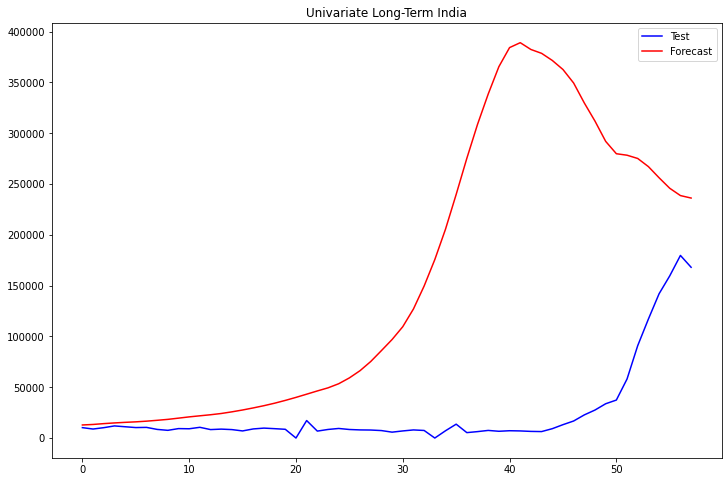

In [63]:
evaluate.plot_fore_test(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm, 'Univariate Long-Term India')

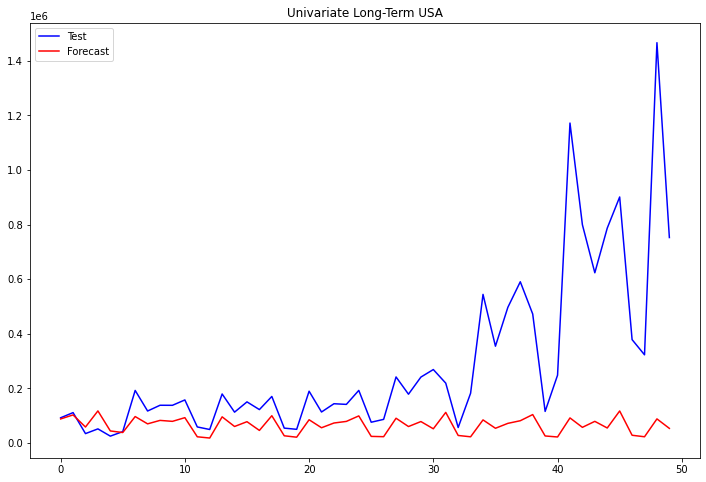

In [64]:
evaluate.plot_fore_test(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm, 'Univariate Long-Term USA')

##### Multivariate

In [65]:
india_multi_test_np_long_denorm

array([ 10229.,   8865.,  10197.,  11919.,  11106.,  10302.,  10488.,
         8488.,   7579.,   9283.,   9119.,  10549.,   8318.,   8774.,
         8309.,   6990.,   8954.,   9765.,   9216.,   8603.,      0.,
        17201.,   6822.,   8439.,   9419.,   8402.,   7990.,   7877.,
         7350.,   5784.,   6984.,   7974.,   7447.,      0.,   7145.,
        13644.,   5326.,   6317.,   7495.,   6650.,   7189.,   6987.,
         6531.,   6358.,   9195.,  13154.,  16764.,  22775.,  27553.,
        33750.,  37379.,  58097.,  90928., 117100., 141986., 159632.,
       179723., 168063.])

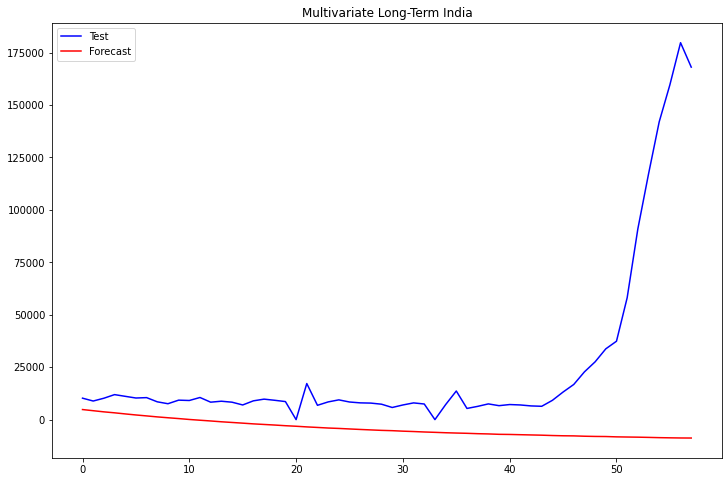

In [66]:
evaluate.plot_fore_test(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm, "Multivariate Long-Term India")

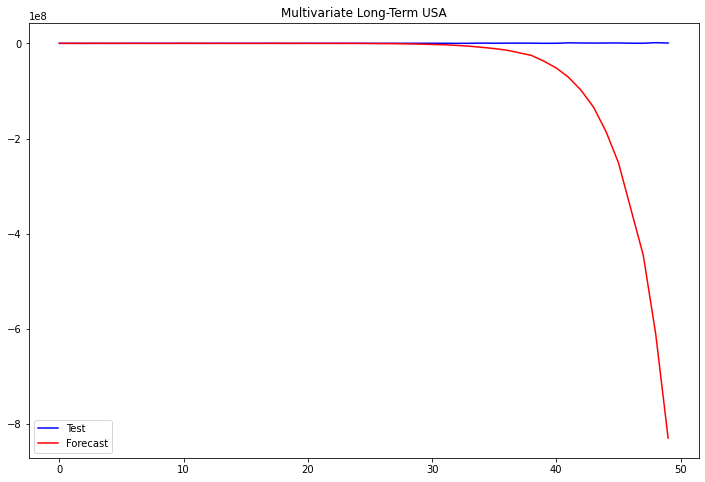

In [67]:
evaluate.plot_fore_test(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm, "Multivariate Long-Term USA")

#### Short-Term Rolling Forecast

##### Univariate

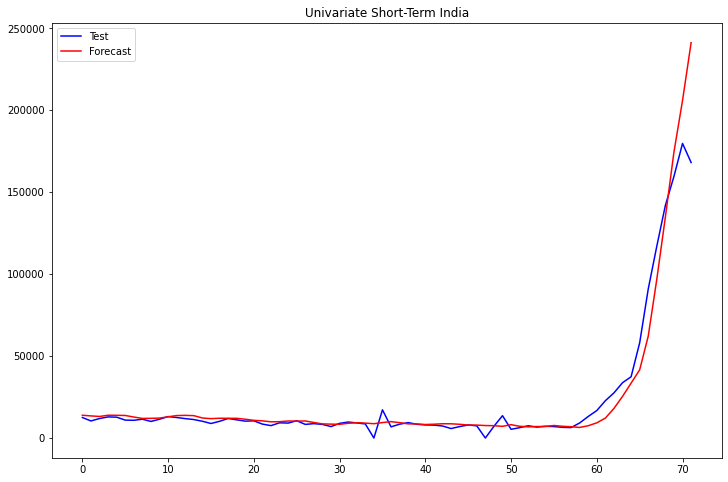

In [68]:
evaluate.plot_fore_test(india_uni_test_short_denorm, yhat_uni_india_short_denorm, "Univariate Short-Term India")

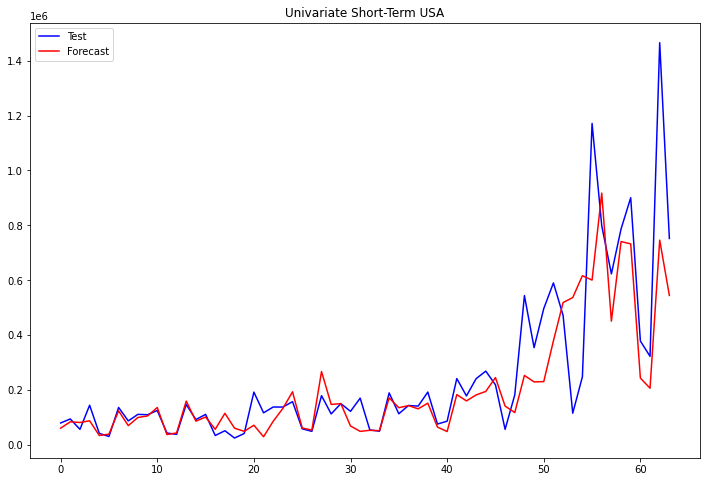

In [69]:
evaluate.plot_fore_test(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm, "Univariate Short-Term USA")

##### Multivariate

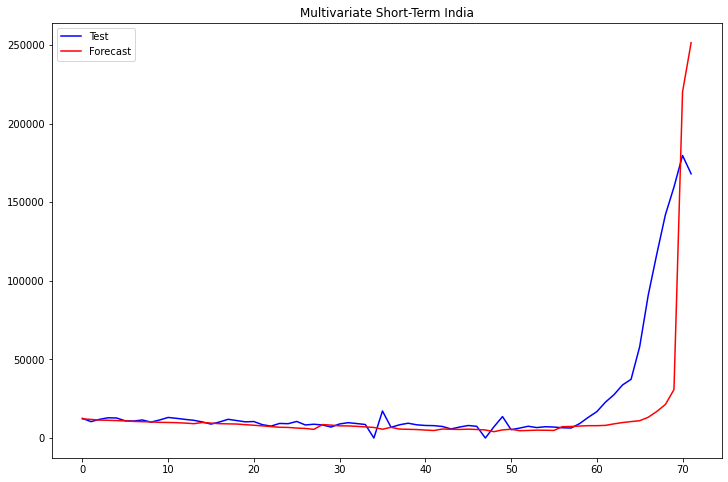

In [70]:
evaluate.plot_fore_test(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm, "Multivariate Short-Term India")

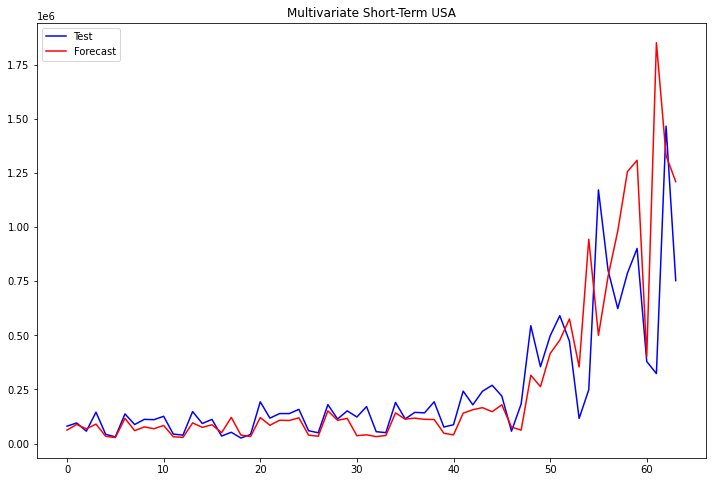

In [71]:
evaluate.plot_fore_test(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm, "Multivariate Short-Term USA")

***
## Save Results
Split = 80:20
India has 568 train, 143 test
Usa has 511 train, 143 test

Long-term predictions have 14 less days in test

In [ ]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
print("Parent Directory", parentDir)
figpath = os.path.join(parentDir,"../figures/lstm")

In [ ]:
import plotting

In [ ]:
dates = india_cases_df.values[1:,0]
dates_df = pd.to_datetime(dates,format='%Y-%m-%d')
dates_df[-129:]

In [ ]:
# Train values India
india_train_df = india_cases_df[['Date','Confirmed']][1:]
india_train_df['Date'] = pd.to_datetime(india_train_df['Date'],format='%Y-%m-%d')
india_train_df.set_index(['Date'],inplace=True)
india_train_df.loc['2021-03-01':]

In [ ]:
# Train values USA
usa_train_df = usa_cases_df[['Date','Confirmed']][1:]
usa_train_df['Date'] = pd.to_datetime(usa_train_df['Date'],format='%Y-%m-%d')
usa_train_df.set_index(['Date'],inplace=True)
usa_train_df

#### Long-Term

In [ ]:
# Univariate India

# Y values
y_india_uni_long_df = pd.DataFrame({'y_india_uni_long':india_uni_test_np_long_denorm})
y_india_uni_long_df.set_index(dates_df[-58:],inplace=True)
print(y_india_uni_long_df.head())

# yhat values
yhat_uni_india_long_df = pd.DataFrame({'yhat_india_uni_long':yhat_uni_india_long_denorm})
yhat_uni_india_long_df.set_index(dates_df[-58:],inplace=True)
print(yhat_uni_india_long_df.head())

In [ ]:
plotting.plot_train_test_fore(train=india_train_df,test=y_india_uni_long_df,fore=yhat_uni_india_long_df,
                              title='India - Long Term',figpath=figpath+'/india_unilstm.eps')

In [ ]:
# Univariate USA

# Y values
y_usa_uni_long_df = pd.DataFrame({'y_usa_uni_long':usa_uni_test_np_long_denorm})
y_usa_uni_long_df.set_index(dates_df[-50:],inplace=True)
print(y_usa_uni_long_df.head())

# yhat values
yhat_uni_usa_long_df = pd.DataFrame({'yhat_usa_uni_long':yhat_uni_usa_long_denorm})
yhat_uni_usa_long_df.set_index(dates_df[-50:],inplace=True)
print(yhat_uni_usa_long_df.head())

In [ ]:
plotting.plot_train_test_fore(train=usa_train_df,test=y_usa_uni_long_df,fore=yhat_uni_usa_long_df,
                              title='USA - Long Term',figpath=figpath+'/usa_unilstm.eps')

In [ ]:
# Multivariate India

# Y values
y_india_multi_long_df = pd.DataFrame({'y_india_multi_long':india_multi_test_np_long_denorm})
# y_india_multi_long_df.set_index(dates_df[-129:],inplace=True)
y_india_multi_long_df.set_index(dates_df[-21:],inplace=True)
print(y_india_multi_long_df.head())

# yhat values
yhat_multi_india_long_df = pd.DataFrame({'yhat_india_multi_long':yhat_multi_india_long_denorm})
# yhat_multi_india_long_df.set_index(dates_df[-129:],inplace=True)
yhat_multi_india_long_df.set_index(dates_df[-21:],inplace=True)
print(yhat_multi_india_long_df.head())

In [ ]:
plotting.plot_train_test_fore(train=india_train_df,test=y_india_multi_long_df,fore=yhat_multi_india_long_df,
                              title='India - Long Term',figpath=figpath+'/india_multilstm.eps')

In [ ]:
# Multivariate USA

# Y values
y_usa_multi_long_df = pd.DataFrame({'y_usa_multi_long':usa_multi_test_np_long_denorm})
y_usa_multi_long_df.set_index(dates_df[-50:],inplace=True)
print(y_usa_multi_long_df.head())

# yhat values
yhat_multi_usa_long_df = pd.DataFrame({'yhat_usa_multi_long':yhat_multi_usa_long_denorm})
yhat_multi_usa_long_df.set_index(dates_df[-50:],inplace=True)
print(yhat_multi_usa_long_df.head())

In [ ]:
plotting.plot_train_test_fore(train=usa_train_df,test=y_usa_multi_long_df,fore=yhat_multi_usa_long_df,
                              title='USA - Long Term',figpath=figpath+'/usa_multilstm.eps')

#### Short-Term 

In [ ]:
# Univariate India

# Y values
y_india_uni_short_df = pd.DataFrame({'y_india_uni_short':india_uni_test_short_denorm})
y_india_uni_short_df.set_index(dates_df[-72:],inplace=True)
print(y_india_uni_long_df.head())

# yhat values
yhat_uni_india_short_df = pd.DataFrame({'yhat_india_uni_short':yhat_uni_india_short_denorm})
yhat_uni_india_short_df.set_index(dates_df[-72:],inplace=True)
print(yhat_uni_india_short_df.head())

In [ ]:
plotting.plot_train_test_fore(train=india_train_df,test=y_india_uni_short_df,fore=yhat_uni_india_short_df,
                              title='India - Short Term',figpath=figpath+'/india_unilstm_rolling.eps')

In [ ]:
# Univariate USA

# Y values
y_usa_uni_short_df = pd.DataFrame({'y_usa_uni_short':usa_uni_test_short_denorm})
y_usa_uni_short_df.set_index(dates_df[-64:],inplace=True)
print(y_usa_uni_short_df.head())

# yhat values
yhat_uni_usa_short_df = pd.DataFrame({'yhat_usa_uni_short':yhat_uni_usa_short_denorm})
yhat_uni_usa_short_df.set_index(dates_df[-64:],inplace=True)
print(yhat_uni_usa_short_df.head())

In [ ]:
plotting.plot_train_test_fore(train=usa_train_df,test=y_usa_uni_short_df,fore=yhat_uni_usa_short_df,
                              title='USA - Short Term',figpath=figpath+'/usa_unilstm_rolling.eps')

In [ ]:
# Multivariate India

# Y values
y_india_multi_short_df = pd.DataFrame({'y_india_multi_short':india_multi_test_np_short_denorm})
y_india_multi_short_df.set_index(dates_df[-72:],inplace=True)
print(y_india_multi_short_df.head())

# yhat values
yhat_multi_india_long_df = pd.DataFrame({'yhat_india_multi_short':yhat_multi_india_short_denorm})
yhat_multi_india_long_df.set_index(dates_df[-72:],inplace=True)
print(yhat_multi_india_long_df.head())

In [ ]:
plotting.plot_train_test_fore(train=india_train_df,test=y_india_multi_short_df,fore=yhat_multi_india_long_df,
                              title='India - Short Term',figpath=figpath+'/india_multilstm_rolling.eps')

In [ ]:
# Multivariate USA

# Y values
y_usa_multi_short_df = pd.DataFrame({'y_usa_multi_short':usa_multi_test_np_short_denorm})
y_usa_multi_short_df.set_index(dates_df[-64:],inplace=True)
print(y_usa_multi_short_df.head())

# yhat values
yhat_multi_usa_short_df = pd.DataFrame({'yhat_usa_multi_short':yhat_multi_usa_short_denorm})
yhat_multi_usa_short_df.set_index(dates_df[-64:],inplace=True)
print(yhat_multi_usa_short_df.head())

In [ ]:
plotting.plot_train_test_fore(train=usa_train_df,test=y_usa_multi_short_df,fore=yhat_multi_usa_short_df,
                              title='USA - Short Term',figpath=figpath+'/usa_multilstm_rolling.eps')